In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import emcee
sb.set_style('white')
%config InlineBackend.figure_format = 'retina'

In [2]:
from model_joint_lnhood import *

In [3]:
Ener,no_events,e_min,e_max = np.loadtxt('data/OC_no_events_15_bins_015_v2.txt',usecols=(0,1,2,3),unpack=True)

In [4]:
mask = no_events != 0.0
Ener = Ener[mask]
no_events = no_events[mask]
e_min = e_min[mask]
e_max = e_max[mask]

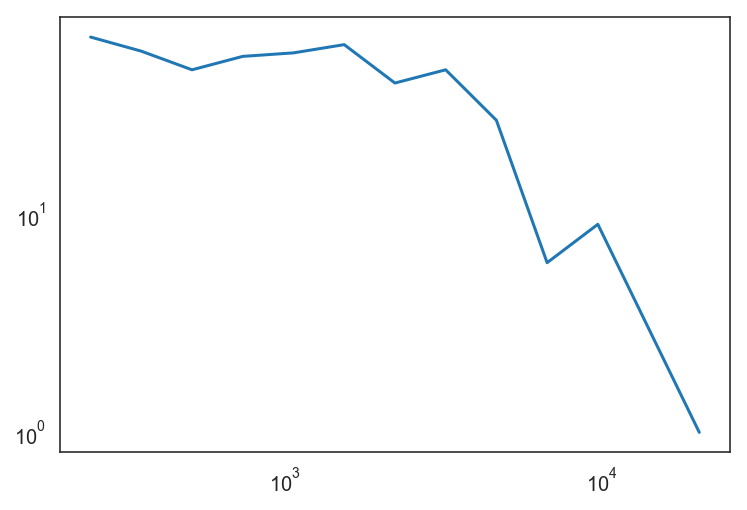

In [5]:
plt.loglog(Ener,no_events);

In [6]:
from scipy import optimize as op

In [7]:
fun = lambda *args: - (lnhood1(*args) + lnhood2(*args))

In [8]:
mid = [1.,6.,-6.,-6.,1.5,-6.,1.5]
bnds = ((0.,3.), (2.,8.), (-18.,0.),(-15.,0.),(0.,5.),(-15.,0.),(0.,5.))

In [9]:
result = op.minimize(fun, mid, args=(no_events,e_min,e_max),method = 'TNC',bounds=bnds)

In [10]:
print(result.x)

[  1.55812824   5.97957804  -9.3947961  -10.23321955   1.06061974
 -12.73516308   1.58944231]


In [11]:
p_list = [0.,3., 2.,8.,-18.,0.,-15.,0.,0.,5.,-15.,0.,0.,5.]

In [12]:
nwalkers = 280
ndim = int((len(p_list)/2))

In [13]:
print(ndim)

7


In [14]:
z = np.zeros((ndim,nwalkers))

In [15]:
start_point = [1.77,3.63,-6.19,-11.43,2.70,-13.96,1.71]

In [16]:
h = 1e-2

pos_i=[]

for i in range(ndim):
    z[i,:] = result.x[i] + h*np.random.randn(nwalkers)

for i in range(nwalkers):
    pos_i.append(np.array([z[0,i],z[1,i],z[2,i],z[3,i],z[4,i],
                          z[5,i],z[6,i]]))

In [17]:
b_steps, steps = 500, 1000

In [18]:
sampler = emcee.EnsembleSampler(nwalkers,ndim,event_lnpost, 
                                args=(no_events,e_min,e_max,p_list),
                                threads = 2)

In [19]:
pos,prob,state=sampler.run_mcmc(pos_i, b_steps)

In [20]:
print(sampler.acceptance_fraction.mean())

0.3053142857142857


In [21]:
sampler.reset()

In [22]:
_,_,_=sampler.run_mcmc(pos, steps, rstate0=state)

In [23]:
print(sampler.acceptance_fraction.mean())

0.35411071428571433


Text(0.5, 0, 'steps')

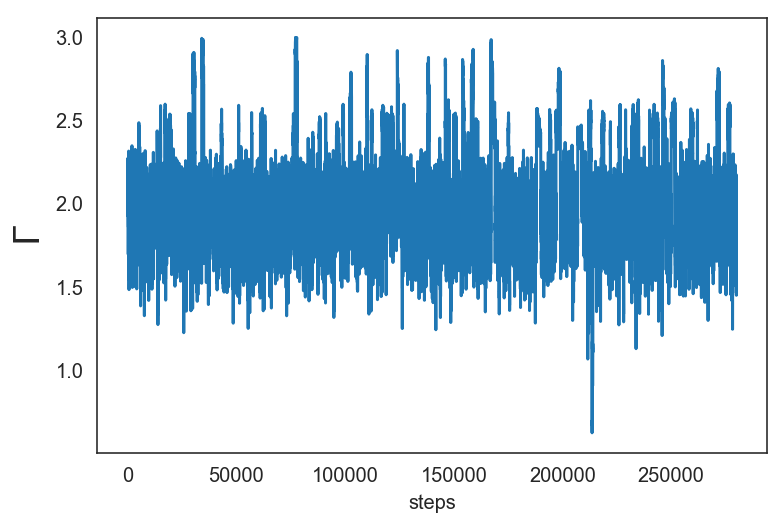

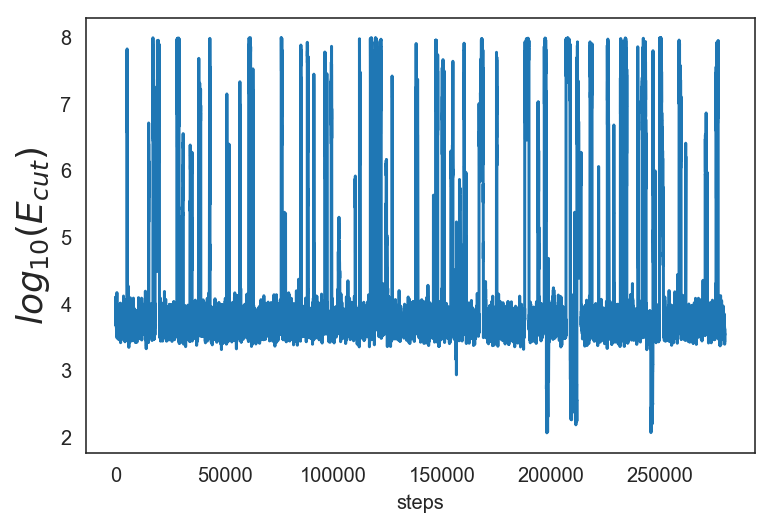

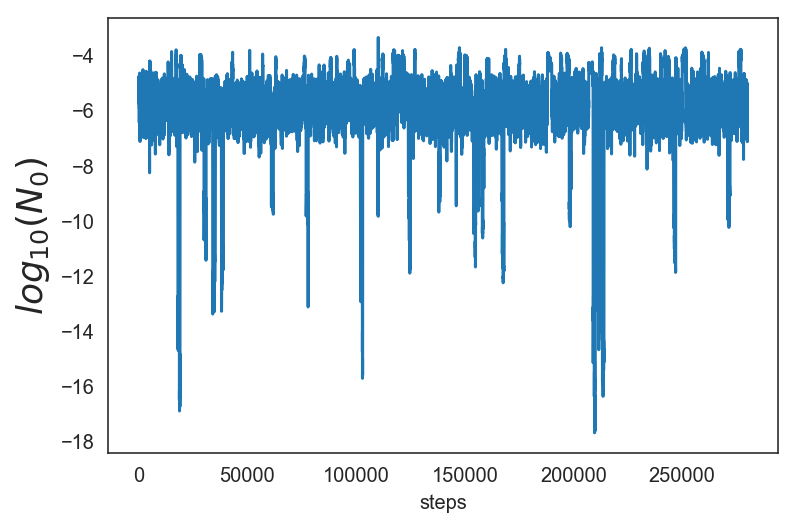

In [24]:
c1 = plt.figure()
plt.plot(sampler.flatchain[:,0]);
plt.ylabel(r'$\Gamma$',fontsize=18)
plt.xlabel('steps')
#c1.savefig('images/chains_gamma_wierd.png')
c2 = plt.figure()
plt.plot(sampler.flatchain[:,1]);
plt.ylabel(r'$log_{10}(E_{cut})$',fontsize=18)
plt.xlabel('steps')
#c2.savefig('images/chains_Ecut_wierd.png')
c3 = plt.figure()
plt.plot(sampler.flatchain[:,2]);
plt.ylabel(r'$log_{10}(N_0)$',fontsize=18)
plt.xlabel('steps')
#c3.savefig('images/chains_N0_wierd.png')

In [25]:
import corner as corner 

In [26]:
labels = [r'$\Gamma$',r'$log10(E_{cut})$','log10(N0)'
          ,r'$log10(N_N1)$',r'$\alpha_1$'
         ,r'$log10(N_N2)$',r'$\alpha_2$']

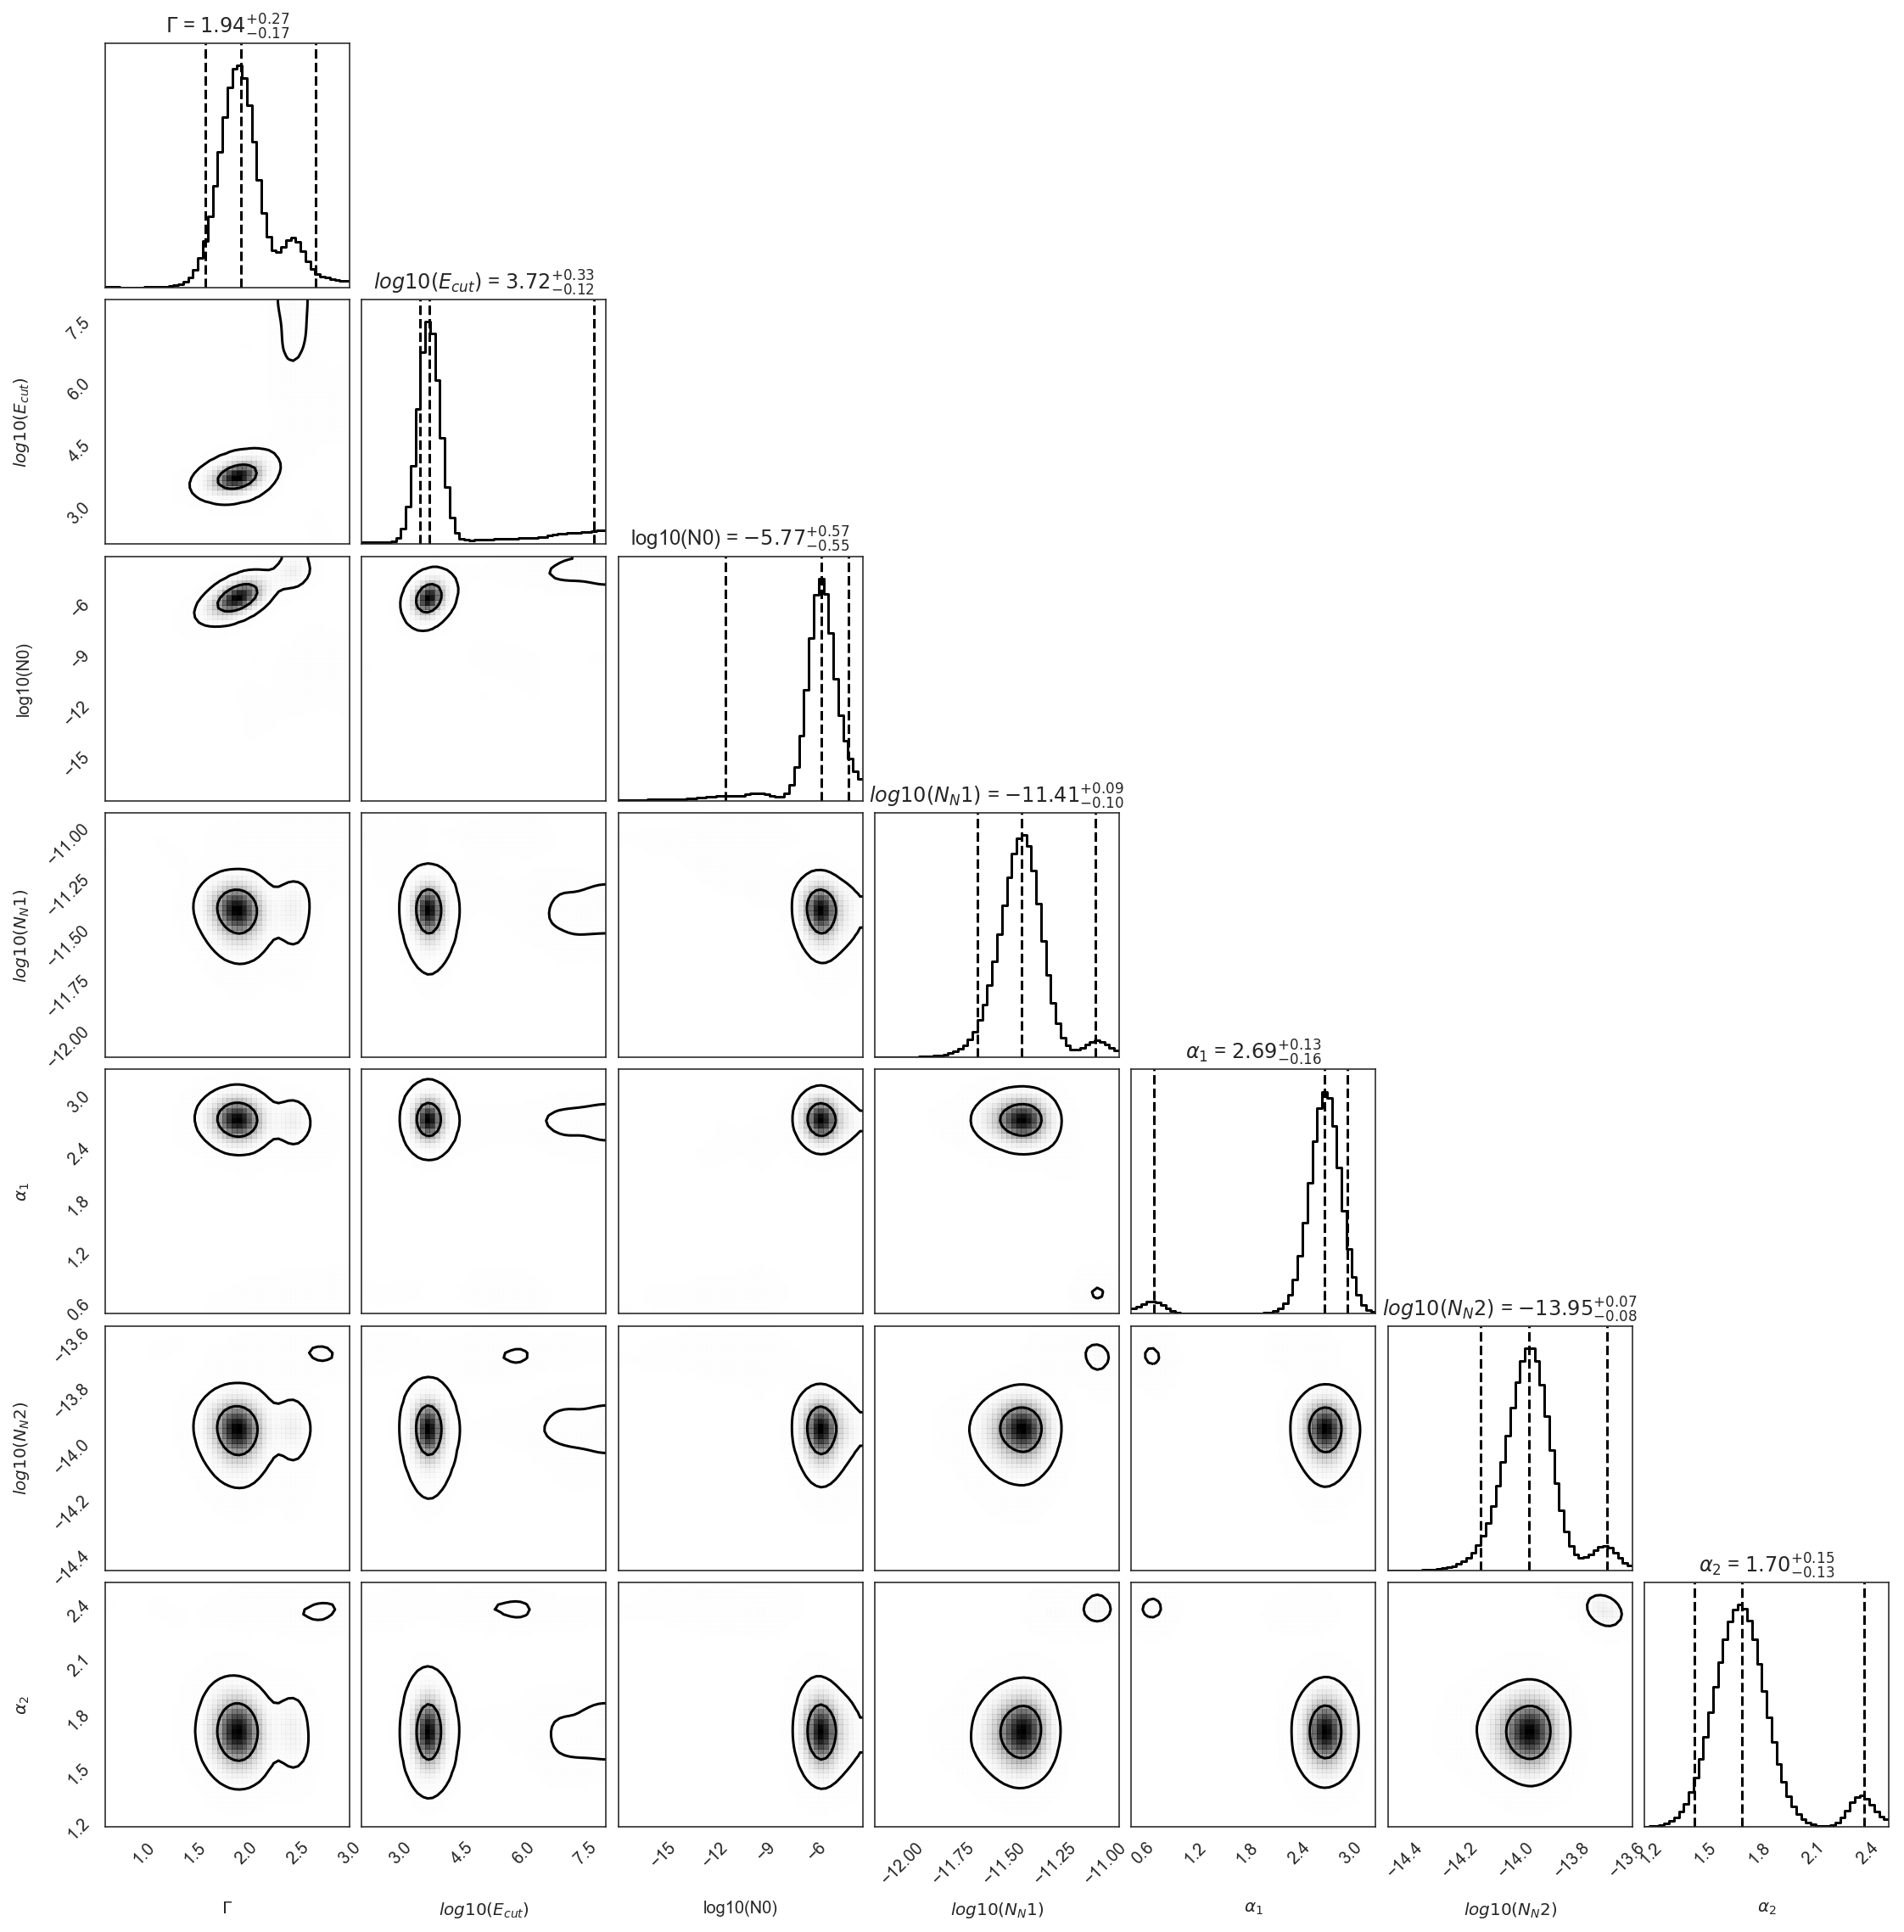

In [27]:
fig = corner.corner(sampler.flatchain,bins=50,labels=labels,plot_datapoints=False,smooth=2., 
                    smooth1d=2,levels=(1.-np.exp(-0.5),1.-np.exp(-2.)),quantiles=[.025,0.5,0.975],show_titles=True);

fig.savefig('images/corner_15_015_v3.pdf')

fig_1.savefig('images/joint_lnhood_plot_gauss.pdf')

Text(0, 0.5, 'No_Events')

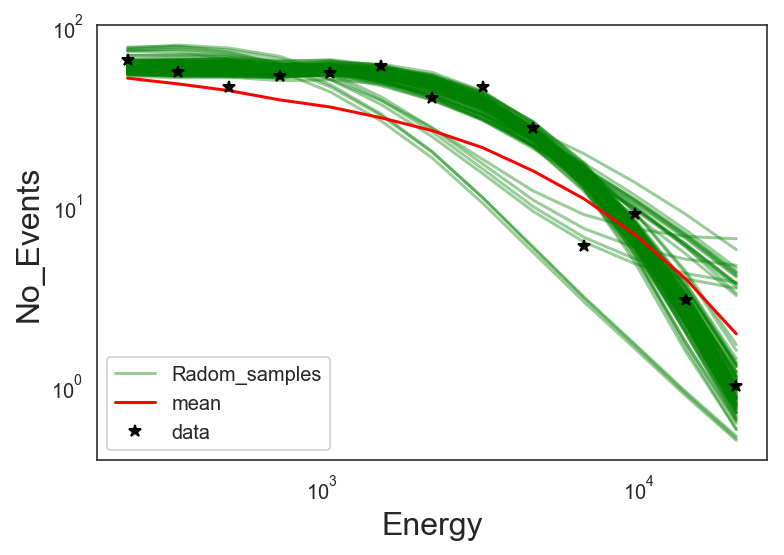

In [28]:
fig1 = plt.figure()

for c1,c2,c3,c4,c5,c6,c7 in sampler.flatchain[np.random.randint(len(sampler.flatchain), size=100)]:
    val_1 = no_events_ocen([c1,c2,c3],e_min,e_max)
    val_2 = no_events_source1([c4,c5],e_min,e_max)
    val_3 = no_events_source2([c6,c7],e_min,e_max)
    fig_1,=plt.loglog(Ener,val_1+val_2+val_3,'g',alpha=0.4);

val1_mean = no_events_ocen([np.mean(sampler.flatchain[:,0]),np.mean(sampler.flatchain[:,1]),np.mean(sampler.flatchain[:,2])],
                                   e_min,e_max)
val2_mean = no_events_source1([np.mean(sampler.flatchain[:,3]),np.mean(sampler.flatchain[:,4])],
                             e_min,e_max)
val3_mean = no_events_source2([np.mean(sampler.flatchain[:,5]),np.mean(sampler.flatchain[:,6])],
                             e_min,e_max)

fig_2,=plt.loglog(Ener,val1_mean+val2_mean+val3_mean,'r');
#fig_2,=plt.plot(Ener,no_events_model_pulsar([np.mean(sampler.flatchain[:,0]),np.mean(sampler.flatchain[:,1]),np.mean(sampler.flatchain[:,2])],e_min,e_max)+ background);
#plt.plot(Ener,no_events,'*b');
fig_3,=plt.loglog(Ener,no_events,'*k');
plt.legend([fig_1,fig_2,fig_3],['Radom_samples','mean','data'],loc='best')
plt.xlabel('Energy',fontsize=16)
plt.ylabel('No_Events',fontsize=16)
#plt.plot(Ener,no_events_model_pulsar([-0.23,3.14,-1.18],e_min,e_max),'b');

fig1.savefig('images/No_events_gauss.pdf')

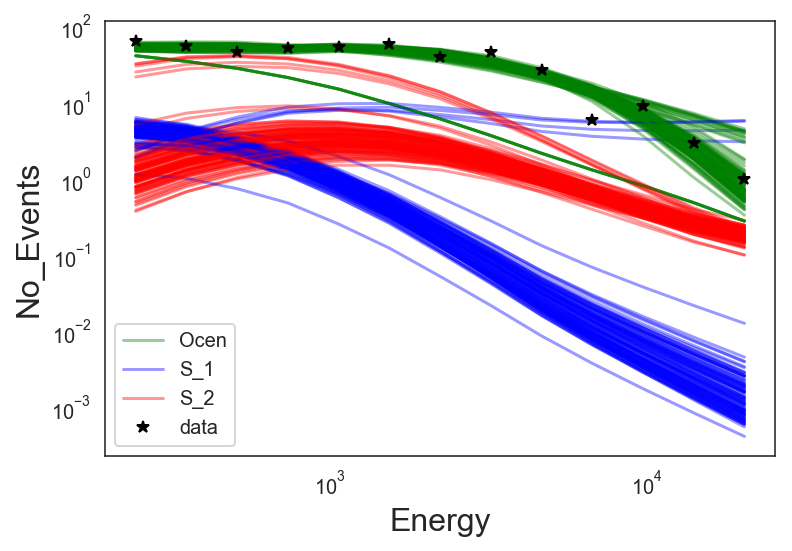

In [29]:
fig1 = plt.figure()
for c1,c2,c3,c4,c5,c6,c7 in sampler.flatchain[np.random.randint(len(sampler.flatchain), size=100)]:
    val_1 = no_events_ocen([c1,c2,c3],e_min,e_max)
    val_2 = no_events_source1([c4,c5],e_min,e_max)
    val_3 = no_events_source2([c6,c7],e_min,e_max)
    fig_1,=plt.loglog(Ener,val_1,'g',alpha=0.4);
    fig_2,=plt.loglog(Ener,val_2,'b',alpha=0.4);
    fig_3,=plt.loglog(Ener,val_3,'r',alpha=0.4);


#fig_2,=plt.plot(Ener,no_events_model_pulsar([np.mean(sampler.flatchain[:,0]),np.mean(sampler.flatchain[:,1]),np.mean(sampler.flatchain[:,2])],e_min,e_max)+ background);
#plt.plot(Ener,no_events,'*b');
fig_4,=plt.loglog(Ener,no_events,'*k');
plt.legend([fig_1,fig_2,fig_3,fig_4],['Ocen','S_1','S_2','data'],loc='best');
plt.xlabel('Energy',fontsize=16);
plt.ylabel('No_Events',fontsize=16);
#plt.plot(Ener,no_events_model_pulsar([-0.23,3.14,-1.18],e_min,e_max),'b');

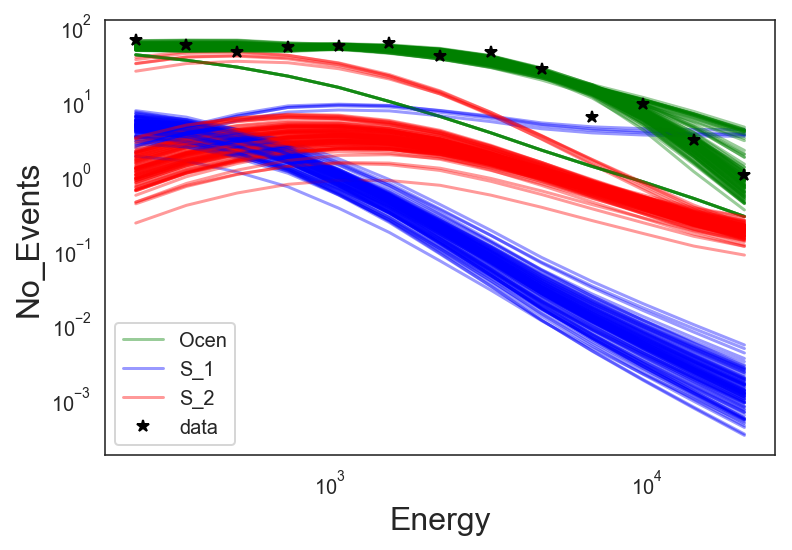

In [30]:
fig1 = plt.figure()
chains_redux = sampler.flatchain[155000:]
for c1,c2,c3,c4,c5,c6,c7 in chains_redux[np.random.randint(len(chains_redux), size=100)]:
    val_1 = no_events_ocen([c1,c2,c3],e_min,e_max)
    val_2 = no_events_source1([c4,c5],e_min,e_max)
    val_3 = no_events_source2([c6,c7],e_min,e_max)
    fig_1,=plt.loglog(Ener,val_1,'g',alpha=0.4);
    fig_2,=plt.loglog(Ener,val_2,'b',alpha=0.4);
    fig_3,=plt.loglog(Ener,val_3,'r',alpha=0.4);


#fig_2,=plt.plot(Ener,no_events_model_pulsar([np.mean(sampler.flatchain[:,0]),np.mean(sampler.flatchain[:,1]),np.mean(sampler.flatchain[:,2])],e_min,e_max)+ background);
#plt.plot(Ener,no_events,'*b');
fig_4,=plt.loglog(Ener,no_events,'*k');
plt.legend([fig_1,fig_2,fig_3,fig_4],['Ocen','S_1','S_2','data'],loc='best');
plt.xlabel('Energy',fontsize=16);
plt.ylabel('No_Events',fontsize=16);
#plt.plot(Ener,no_events_model_pulsar([-0.23,3.14,-1.18],e_min,e_max),'b');

In [31]:
def N_Pulsars_Ecut(chains):

    d = 5.2 * (1000.*100.) * 3.0857e16 #cm
    eta = 0.08
    E_dot = 2.0e34
    
    S = np.zeros(len(chains))
    
    for i in range(len(chains)):
        
        C_s = [chains[i,0],chains[i,1],chains[i,2]]
        integrand = lambda x: x * E2dNdE_pulsar(C_s,x)
        
        S[i] = integrate.quad(integrand,0.01,np.inf)[0]
    
    L = 4.0 * np.pi * S * d**2
    N_events = (L*1.602e-6) /(E_dot * eta)
    
    return N_events

In [32]:
chain_Np = N_Pulsars_Ecut(sampler.flatchain)

/Users/Oleg/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  


In [33]:
new_chain = np.append(sampler.flatchain,chain_Np[:,None],axis=1)

In [34]:
labels_2 = [r'$\Gamma$',r'$log10(E_{cut})$','log10(N0)'
          ,r'$log10(N_N1)$',r'$\alpha_1$'
         ,r'$log10(N_N2)$',r'$\alpha_2$',r'$N_{Pulsars}$']

In [35]:
ranges = ((1.2,2.3), (3.3,5.6), (-8.,-4.),(-12.,-11.),(2,3.5),(-15.,-13.6),(1,2.5),(0,200))

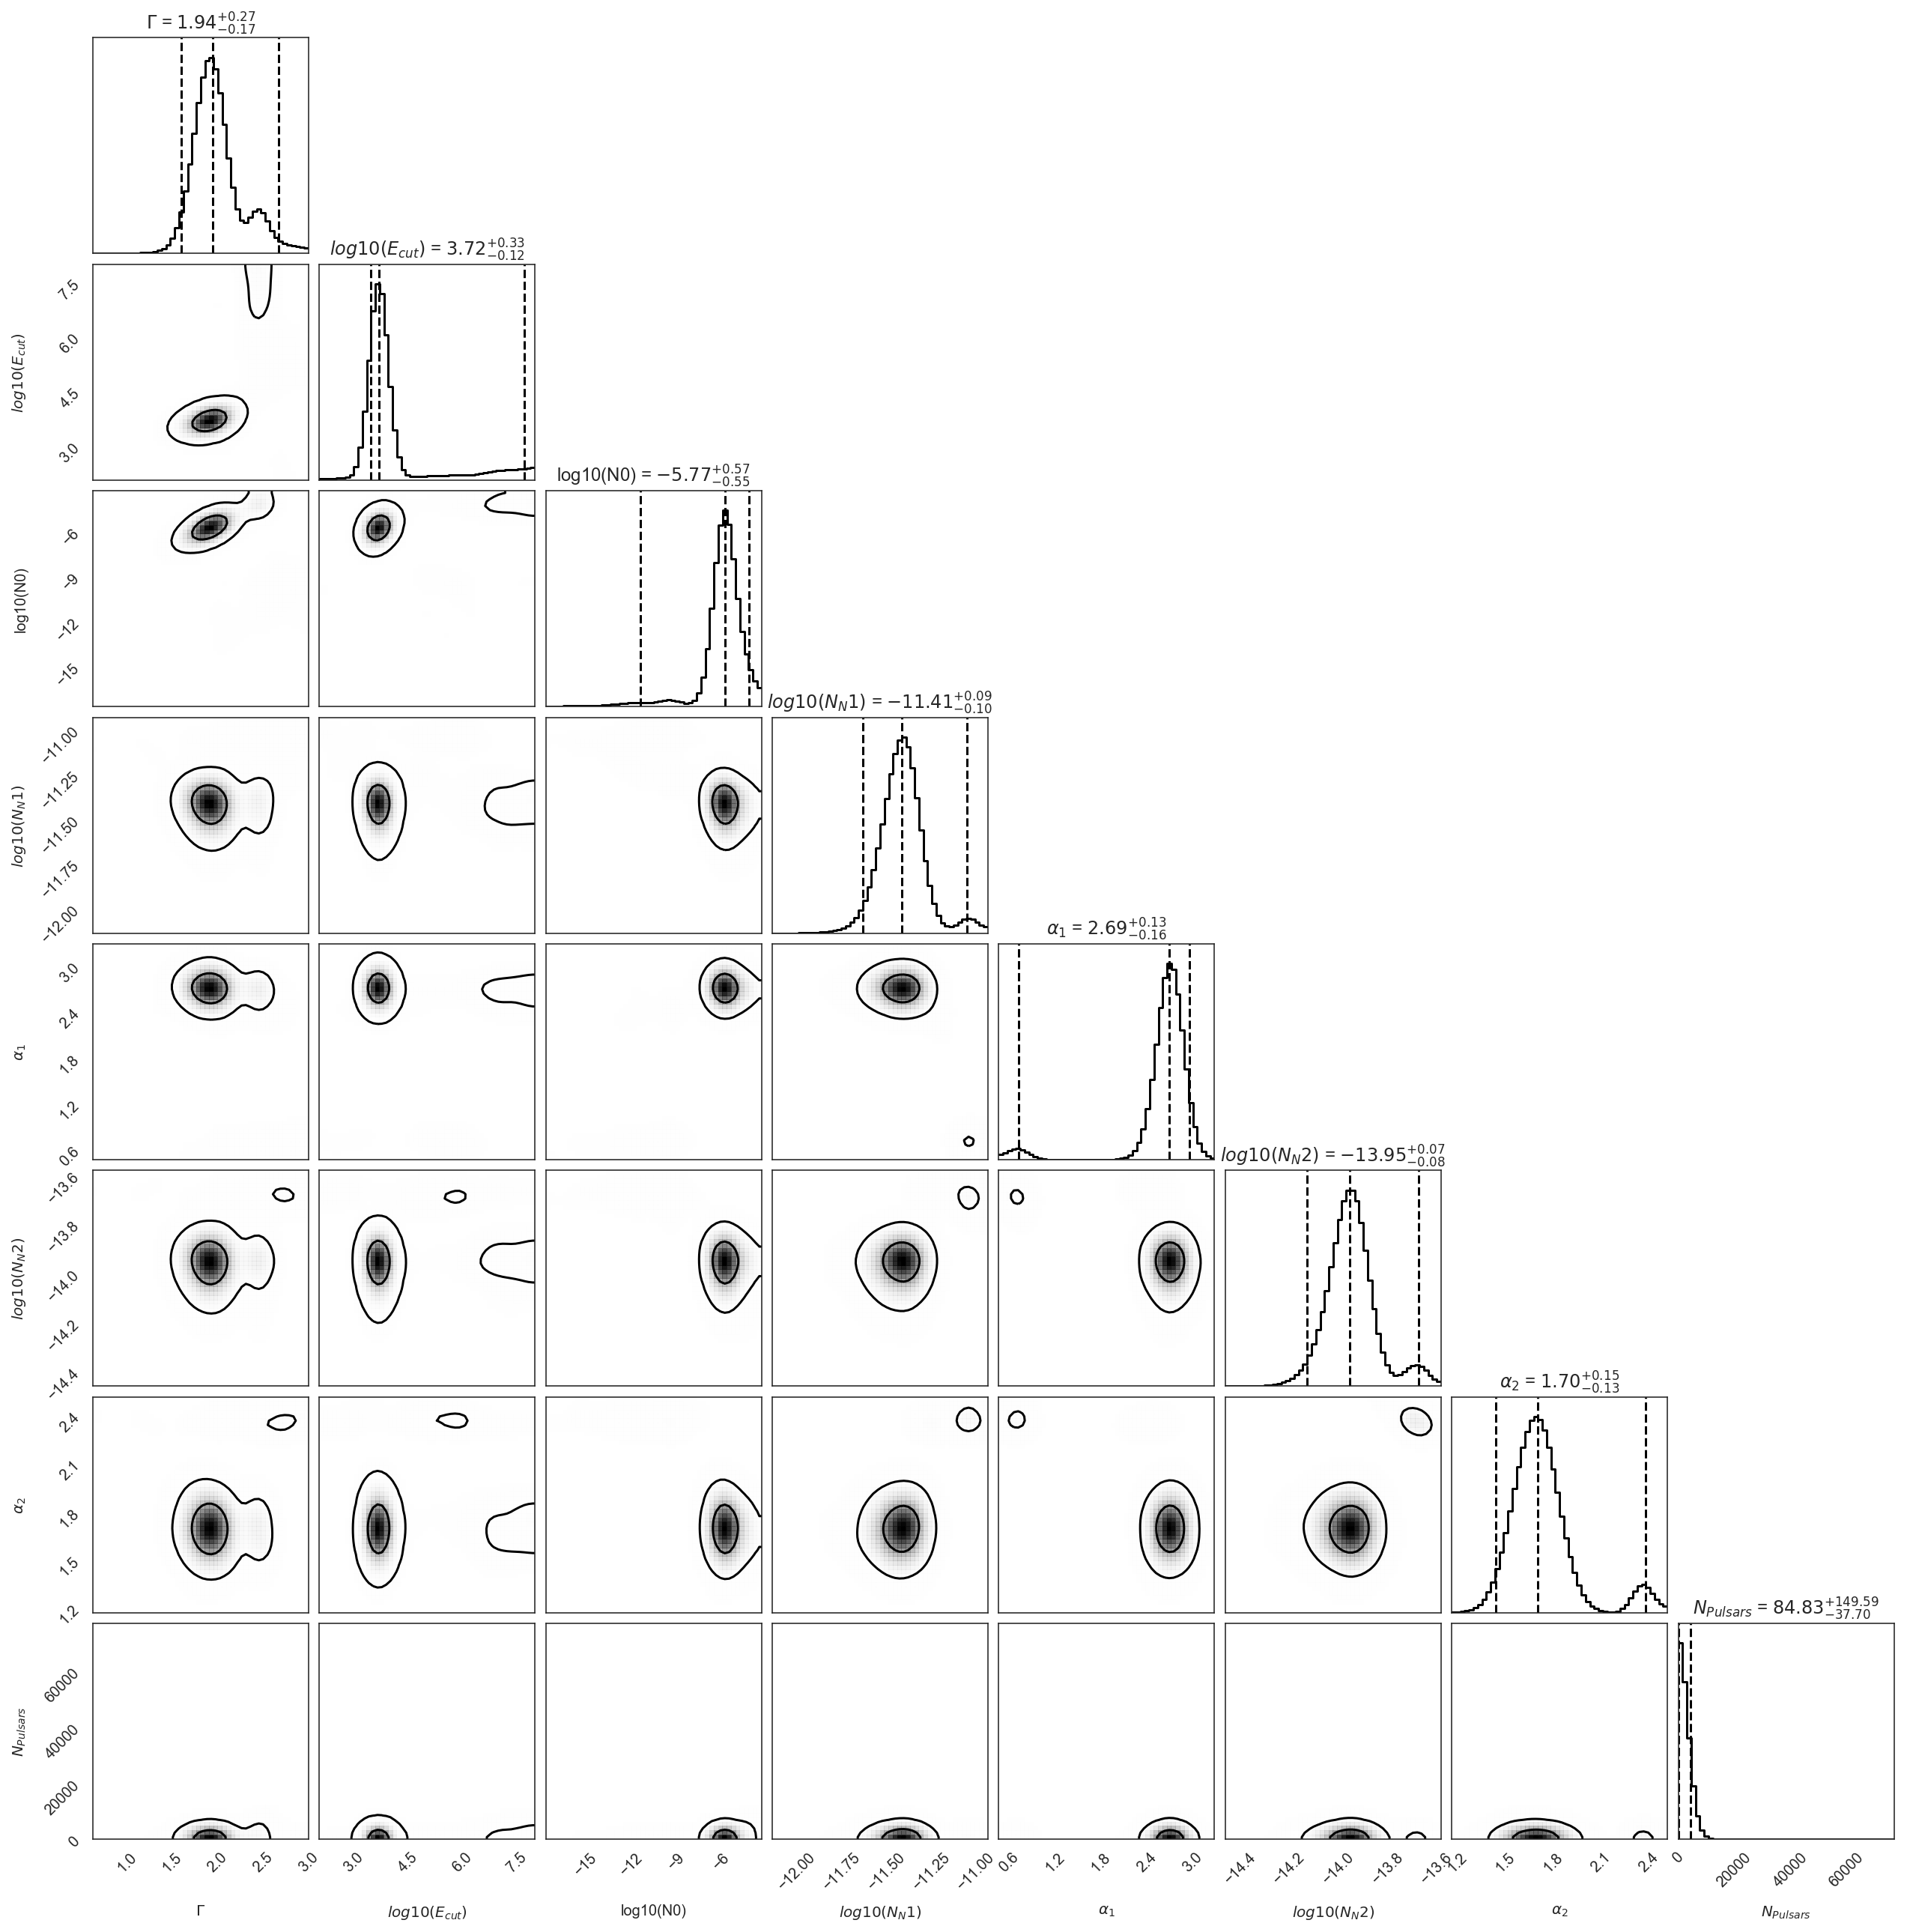

In [36]:
fig_count= corner.corner(new_chain,bins=50,labels=labels_2,plot_datapoints=False,smooth=2., 
                    smooth1d=2,levels=(1.-np.exp(-0.5),1.-np.exp(-2.)),quantiles=[.025,0.5,0.975],show_titles=True);

fig_count.savefig('images/MSP_15_bins_05_new_test.pdf')

In [37]:
np.savetxt('chains/msp_chains_015_new_test_v2.dat',new_chain)

np.savetxt('chains/msp_sampler_chains_02_degree_v2.dat',sampler.flatchain)